# DATA PREPROCESSING

In [1]:
import pandas as pd

ratings = pd.read_csv('/content/drive/MyDrive/Movie Recommender System/ml-latest-small/ratings.csv')
movies = pd.read_csv('/content/drive/MyDrive/Movie Recommender System/ml-latest-small/movies.csv')
tags = pd.read_csv('/content/drive/MyDrive/Movie Recommender System/ml-latest-small/tags.csv')
links = pd.read_csv('/content/drive/MyDrive/Movie Recommender System/ml-latest-small/links.csv')

**CLEANING THE DATA**

In [2]:
# Check for null values

#ratings.isnull().any()
#movies.isnull().any()
#tags.isnull().any()
links.isnull().any()

,0
movieId,False
imdbId,False
tmdbId,True


links.csv data has missing values in the 'tmdbld' column

Now lets see how many missng values it has:

In [3]:
links.isnull().sum()

,0
movieId,0
imdbId,0
tmdbId,8


In [4]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Now since the missing values are from the tmdbId column which is an Identifier for movies used by 'themoviedb.org' I do not think that I will need it to build this recommendation system and hence I will just drop the column

In later iterations I might just look for the actual Identifiers since there are only 8 missing

In [5]:
# Drop column with missing values
links_clean = links.drop('tmdbId', axis=1)
links_clean.head()

,movieId,imdbId
0,1,114709
1,2,113497
2,3,113228
3,4,114885
4,5,113041


In [6]:
# Check for duplicates
ratings_duplicates = ratings.duplicated().sum()
movies_duplicates = movies.duplicated().sum()
tags_duplicates = tags.duplicated().sum()
links_duplicates = links.duplicated().sum()
ratings_duplicates, movies_duplicates, tags_duplicates, links_duplicates

# No duplicates

(0, 0, 0, 0)

In [7]:
# Converting timestamps into readable dates(ratings data)

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [8]:
# Movies Data
# Splitting genres column into list of genres
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


You may get an AttributeError when running the above program, it's because I have already run it and the genres are already split.

In [9]:
# Extracting year from titles
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

# Removing years from titles
movies['title'] = movies['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()
movies.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [10]:
# Tags Data
# Convert timestamps to datetime
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,2015-10-24 19:29:54
1,2,60756,Highly quotable,2015-10-24 19:29:56
2,2,60756,will ferrell,2015-10-24 19:29:52
3,2,89774,Boxing story,2015-10-24 19:33:27
4,2,89774,MMA,2015-10-24 19:33:20


In [11]:
# Group tags by movie for CBF
movie_tags = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
movie_tags.head()

,movieId,tag
0,1,pixar pixar fun
1,2,fantasy magic board game Robin Williams game
2,3,moldy old
3,5,pregnancy remake
4,7,remake


# EXPLORATORY DATA ANALYSIS

Now lets analyse our data to see if we can gain some insights

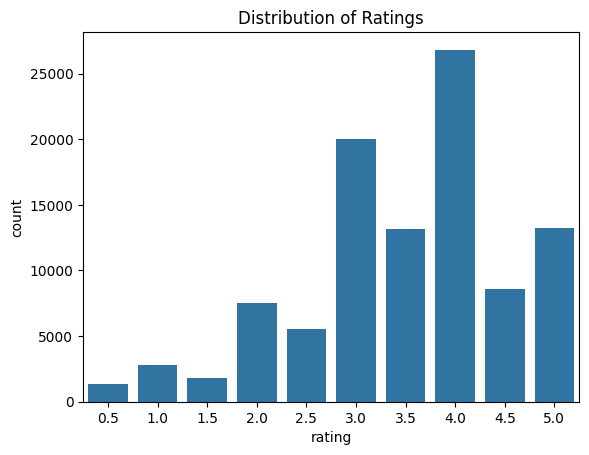

In [12]:
# Ratings

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting distribution of ratings
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.show()

Now from the distribution of our ratings we can see that most movies are higly rated, the most frequent rating being 4/5 followed by 3/5

I will check but I think this dataset is about 20 years old if not more, I would assume since Netflix is close to that age and things just compounded from there with other streaming platforms like Prime and Goojara👀.

There have been more movies and a greater audience.

So this says a lot of the quantity of quality.

Notably is the 4.5, is it just people hating on a great movie or them being extremely critical movie lovers.

Or maybe it's because this data was gathered from different sites.One I'm reminded that I dropped from links data.

In [13]:
# Most rated movies

# Merging ratings with movies
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Top 10 movies with the highest ratings
top_rated_movies = movie_ratings['title'].value_counts().head(10)
top_rated_movies

,count
title,
Forrest Gump,329
"Shawshank Redemption, The",317
Pulp Fiction,307
"Silence of the Lambs, The",279
"Matrix, The",278
Star Wars: Episode IV - A New Hope,251
Jurassic Park,238
Braveheart,237
Terminator 2: Judgment Day,224


Now I have never watched Silence of the lambs and Shawshank Redemption but the rest of the top 10 makes sense, its all movies that me and the people I know would agree that are good and the rest you can just tell from social media commentary that they belong in this list

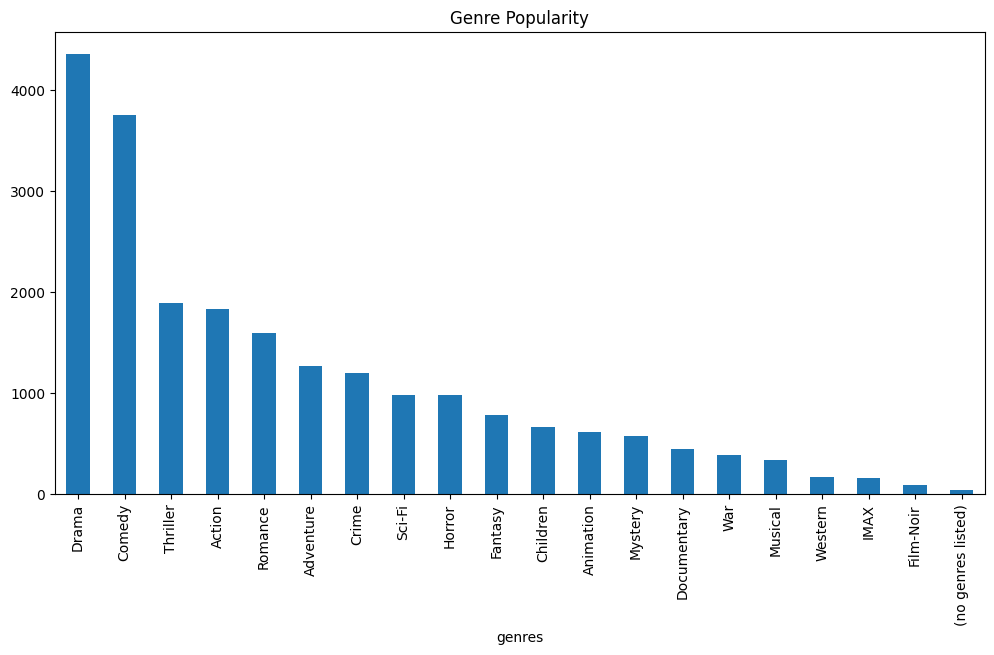

In [14]:
# Which genres are the most popular

# Count movies per genre
genre_counts = movies.explode('genres')['genres'].value_counts()

# Plotting the distribution of genres
genre_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Genre Popularity')
plt.show()

I guess everybody loves drama and comedy, and the culture has changed quite a lot so musicals and western movies aren't as popular.

But documentaries? Are we getting more ignorant or what 😥

Another note sci-fi and horror have the same numbers, makes me think they either have the same audience or similar audience but devided.

Cause both horror and sci-fi have the same thing in common, just from the genre name you know it's Obviously fiction.

# Collaborative Filtering Model

We use the ratings data to build a collaborative filtering model

In [15]:
# User-Item Matrix
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Median rating
median_rating = ratings['rating'].median()

# Mean rating
mean_rating = ratings['rating'].mean()

# Fill NaN values with median
#user_item_matrix_filled = user_item_matrix.fillna(median_rating)

# Fill NaN values with 0
user_item_matrix_filled = user_item_matrix.fillna('0')

# Fill NaN values with mean
#user_item_matrix_filled = user_item_matrix.fillna(mean_rating)

user_item_matrix_filled.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0,4.0,0,0,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505174 sha256=f47f8e12ce47426b84cd4168fbe484c35ae6c67bf30035ef3519c68e82ca4931
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
# Matrix Factorization(SVD) or Single Value Decomposition for collaborative filtering

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Load data into surprise format
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train SVD model
model = SVD()
model.fit(trainset)

# Evaluate model
from surprise import accuracy
predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8752


0.8751504751495833

From my root mean square error above it means that my predicted ratings are off by 0.877 from the actual ratings, to mee this is a big problem beacuse I want them to get to 0 as much as possible, so 0.5 or less would be good.

So I changed my code so that it fills the null values with 0 instead and it changed the error to 0.873 which is just and improvement of 0.004.

Changing the null values to the mean just slightly improves it by 0.001.

So 0 seems sike the best rating for no ratings.

I ran this model with the 0 notification 2 more times.
The first time I ran from the start of the collaborative filtering part and the second time the whole file.

The first time it changed to 0.876 and the second time to 0.8700
I am not sure what's going on.

Third time when I ran all it said 0.871.
Like Which Todd Failed.

# Content-Based Filtering Model

We use movie metadata like genres and tags for content-based recommendations

- Use TF-IDF for text-based features
- Use one-hot encoding for genres

In [ ]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [ ]:
movies['metadata'].isnull().any()

KeyError: 'metadata'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine genres and tags
movies['metadata'] = movies['genres'].apply(lambda x: ' '.join(x)) + ' ' + movie_tags['tag'].fillna('')
movies['metadata'] = movies['metadata'].fillna('')

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['metadata'])

**Cosine Similarity**

Compute similarity between movies.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create mappings of movie titles to indices
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

indices

In [ ]:
# Recommendation Function

def get_content_based_recommendations(title, cosine_sim=cosine_sim, indices=indices):
  index = indices[title]
  sim_scores = list(enumerate(cosine_sim[index]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:11] # This gets the top 10 similar movies
  movie_indices = [i[0] for i in sim_scores]
  return movies['title'].iloc[movie_indices]

# Check
get_content_based_recommendations('Into the Badlands')

Using Jumanji as an example and finding movies that are similar was quite interesting.

I think these movies recommended because of their genre, being for both kids and adults and being highly rated.

# Saving My Models

In [ ]:
from joblib import dump

dump(model, 'collaborative_filtering_model.joblib'),
dump(tfidf, 'content_based_filtering_model.joblib')

Now next time I can just load it and just insert the larger test set.

In [ ]:
# Loading models

#from joblib import load

#model = load('collaborative_filtering_model.joblib')
#tfidf = load('content_based_filtering_model.joblib')

